# MODULE INSTALLATIONS AND IMPORTS

In [ ]:
!pip install python-dotenv boto3 wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 6.6 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=351f5bd0c977787e9f72dcb5987915dea3242d238f89825055fda2c4c0866f25
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
# MODULE IMPORTS
import requests
import os
import tensorflow as tf
import yfinance as yf
import pandas as pd
import datetime
import pickle
import matplotlib.pyplot as plt
import numpy as np
import boto3
import io
import wget
import json
import time


from dotenv import load_dotenv
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

#MODEL INIT

In [ ]:
MODEL_CONFIG = dict(
    name = "win_outcome",
    version = "v1.0"
)

load_dotenv("boto3_cloudflare.env")

True

# LOADING THE DATA DATA

In [ ]:
# TRAINING DATASET
X = pd.read_csv(f"https://raw.githubusercontent.com/lebyanelm/neural-trained-models/main/relative_datasets/cleaned/{MODEL_CONFIG['name']}-{MODEL_CONFIG['version']}-train-set.csv").drop_duplicates().dropna()
Y = X.pop("target")
f"""TRAINING SHAPE: {X.shape}"""

'TRAINING SHAPE: (5392, 21)'

In [ ]:
# TESTING/EVALUATION DATASET
X_test = pd.read_csv(f"https://raw.githubusercontent.com/lebyanelm/neural-trained-models/main/relative_datasets/cleaned/{MODEL_CONFIG['name']}-{MODEL_CONFIG['version']}-test-set.csv").drop_duplicates().dropna()
Y_test = X_test.pop("target")
f"""TESTING SHAPE: {X_test.shape}"""

'TESTING SHAPE: (1349, 21)'

In [ ]:
del X_test["id"]
del X_test["scoreHomeFt"]
del X_test["scoreAwayFt"]
del X_test["scoreHomeHt"]
del X_test["scoreAwayHt"]
del X_test["h2hHomeLosses"]
del X_test["h2hAwayLosses"]
del X_test["h2hHomeWins"]
del X_test["h2hAwayWins"]
del X_test["h2hDraws"]

del X["id"]
del X["scoreHomeFt"]
del X["scoreAwayFt"]
del X["scoreHomeHt"]
del X["scoreAwayHt"]
del X["h2hHomeLosses"]
del X["h2hAwayLosses"]
del X["h2hHomeWins"]
del X["h2hAwayWins"]
del X["h2hDraws"]
X

,day,month,year,weekday,hour,minute,matchday,leagueType,homeId,awayId,h2hAvgGoals
0,15.0,9.0,2021.0,3.0,18.0,45.0,7.0,0.0,332.0,63.0,3.4
1,29.0,10.0,2022.0,6.0,13.0,30.0,12.0,0.0,11.0,36.0,3.2
2,20.0,11.0,2021.0,6.0,15.0,0.0,18.0,0.0,355.0,351.0,2.4
3,16.0,10.0,2021.0,6.0,11.0,30.0,12.0,0.0,63.0,69.0,3.0
4,6.0,12.0,2023.0,3.0,20.0,0.0,10.0,0.0,516.0,523.0,2.2
...,...,...,...,...,...,...,...,...,...,...,...
5387,3.0,4.0,2024.0,3.0,18.0,30.0,31.0,0.0,402.0,397.0,2.6
5388,18.0,9.0,2022.0,7.0,15.0,30.0,7.0,0.0,36.0,1.0,2.6
5389,27.0,2.0,2022.0,7.0,14.0,0.0,26.0,0.0,512.0,525.0,2.4
5390,1.0,10.0,2022.0,6.0,14.0,30.0,8.0,0.0,1909.0,674.0,5.2


In [ ]:
X_test.describe()

,day,month,year,weekday,hour,minute,matchday,leagueType,homeId,awayId,h2hAvgGoals
count,1349.000000,1349.000000,1349.000000,1349.000000,1349.000000,1349.000000,1349.000000,1349.000000,1349.000000,1349.000000,1349.000000
mean,15.160860,6.259451,2022.475167,5.425500,15.110452,15.163084,18.234989,0.073388,805.082283,718.323202,2.830875
std,9.069305,3.693887,0.943673,1.744802,4.105123,18.140854,11.682512,0.260869,1572.557860,1366.407474,0.916921
min,1.000000,1.000000,2021.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.400000
25%,7.000000,3.000000,2022.000000,5.000000,14.000000,0.000000,8.000000,0.000000,98.000000,76.000000,2.200000
50%,15.000000,5.000000,2022.000000,6.000000,15.000000,0.000000,18.000000,0.000000,389.000000,397.000000,2.800000
75%,23.000000,10.000000,2023.000000,7.000000,18.000000,30.000000,27.000000,0.000000,586.000000,666.000000,3.400000
max,31.000000,12.000000,2024.000000,7.000000,22.000000,55.000000,46.000000,1.000000,10137.000000,10137.000000,7.500000


# UTILITIY FUNCTIONS

In [ ]:
def save_model_as_tflite():
    model_name = f"{MODEL_CONFIG['name']}-{MODEL_CONFIG['version']}-trained"
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(f"{MODEL_CONFIG['name']}-{MODEL_CONFIG['version']}-trained.tflite", 'wb') as f:
      f.write(tflite_model)
      upload_file_to_s3(f"{MODEL_CONFIG['name']}-{MODEL_CONFIG['version']}-trained.tflite")
      return update_model_registry()


def download_model_registry():
  MODEL_REGISTRY_URL = "https://pub-ba4661e63af44a79ad77bca3e90d5408.r2.dev/models-registry.json"
  request = requests.get(MODEL_REGISTRY_URL)
  with open("models-registry.json", "wb") as registry:
    registry.write(request.content)
    registry.close()
    return json.loads(request.text)
MODELS_REGISTRY = download_model_registry()


def update_model_registry():
    with open("models-registry.json", "wb") as registry:
      file_contents = json.dumps(MODELS_REGISTRY)
      registry.write(file_contents.encode())
      print("Updated registry:", MODELS_REGISTRY)

      registry.close()
      time.sleep(10)
      upload_file_to_s3("models-registry.json")
      return "Updated registry file."


def upload_file_to_s3(f_name):
  with open(f_name, "rb") as f:
    s3 = boto3.client(
      service_name ="s3",
      endpoint_url = os.environ["R2_ENDPOINT"],
      aws_access_key_id = os.environ["R2_ACCESS_KEY_ID"],
      aws_secret_access_key = os.environ["R2_SECRET_KEY"],
      region_name="auto", # Must be one of: wnam, enam, weur, eeur, apac, auto
    )

    file_content = f.read()
    s3.upload_fileobj(io.BytesIO(file_content), "trained-models", Key=f_name)
    print("Uploaded contents:", file_content)

    MODELS_REGISTRY["models"][MODEL_CONFIG["league_name"]] = f_name
    print(f"Uploaded {f_name} to S3")

# Oversampling

In [ ]:
# Randomly oversample the data to equalize the buy/sell count
ros = RandomOverSampler()
X_sampled, Y_sampled = ros.fit_resample(X, Y)
print("Random Over Sampler: ", X_sampled.shape)

Random Over Sampler:  (6022, 11)


array([[<Axes: title={'center': 'target'}>]], dtype=object)

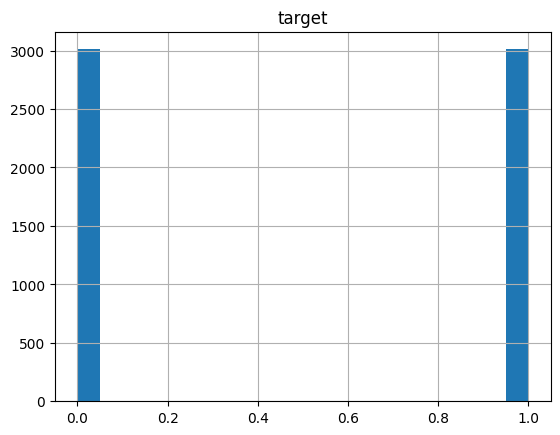

In [ ]:
pd.DataFrame(Y_sampled).hist(bins=20)

In [ ]:
train_scaler = MinMaxScaler()
X_scaled = train_scaler.fit_transform(X)

In [ ]:
model = RandomForestClassifier(n_estimators=10)
model.fit(X, Y)

RandomForestClassifier(n_estimators=10)

In [ ]:
check_index = 10
print(Y_test[check_index])
model.predict_proba(X_test.values[check_index].reshape(1, -1))

0.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.6, 0.4]])

# Sports Model

In [ ]:
num_trees = 10 #10

# Define the number of features
num_features = X_scaled.shape[1]

# Define the depth of each decision tree
max_depth = 3 #3

# Define the input layer
input_layer = tf.keras.layers.Input(shape=(num_features,))

# Initialize an empty list to store the outputs of individual decision trees
tree_outputs = []

# Create each decision tree
for _ in range(num_trees):
    # Define the decision tree branch
    branch = input_layer
    for _ in range(max_depth):
        branch = tf.keras.layers.Dense(units=32, activation='relu')(branch)  # Example dense layer, units=32
    tree_outputs.append(branch)

# Concatenate the outputs of all decision trees
concatenated_output = tf.keras.layers.Concatenate()(tree_outputs)

# Add a final layer for prediction
output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(concatenated_output)

# Create the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
history = model.fit(X_scaled, Y.values, epochs=150, batch_size=32, verbose=1)
MODEL_CONFIG["model_type"] = "tensorflow"

Epoch 1/150
169/169 [==============================] - 8s 6ms/step - loss: 0.6895 - accuracy: 0.5553
Epoch 2/150
169/169 [==============================] - 1s 9ms/step - loss: 0.6846 - accuracy: 0.5575
Epoch 3/150
169/169 [==============================] - 2s 9ms/step - loss: 0.6830 - accuracy: 0.5645
Epoch 4/150
169/169 [==============================] - 2s 9ms/step - loss: 0.6813 - accuracy: 0.5593
Epoch 5/150
169/169 [==============================] - 1s 6ms/step - loss: 0.6800 - accuracy: 0.5660
Epoch 6/150
169/169 [==============================] - 1s 7ms/step - loss: 0.6805 - accuracy: 0.5718
Epoch 7/150
169/169 [==============================] - 1s 5ms/step - loss: 0.6772 - accuracy: 0.5733
Epoch 8/150
169/169 [==============================] - 1s 7ms/step - loss: 0.6770 - accuracy: 0.5744
Epoch 9/150
169/169 [==============================] - 1s 8ms/step - loss: 0.6752 - accuracy: 0.5809
Epoch 10/150
169/169 [==============================] - 1s 8ms/step - loss: 0.6751 - accura

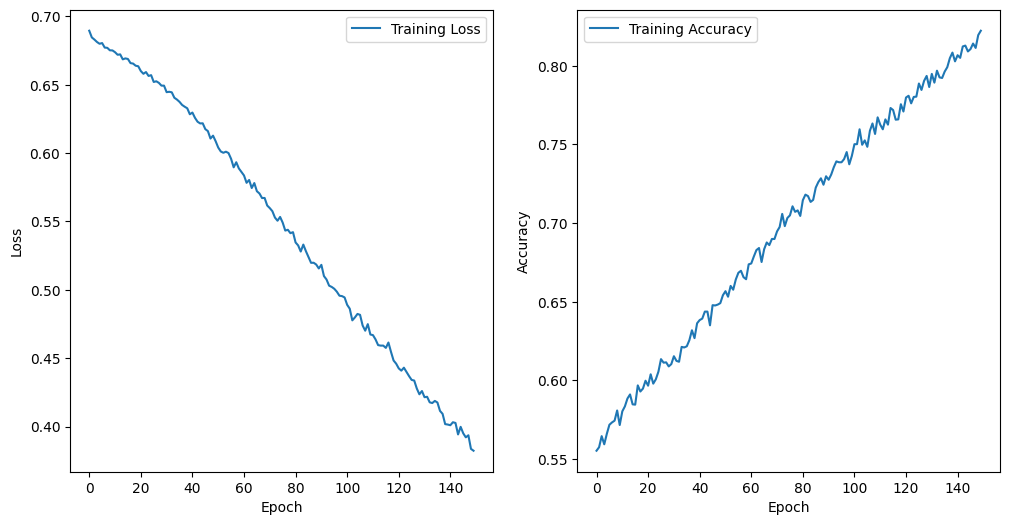

In [ ]:
# Extract loss and accuracy from training history
loss = history.history['loss']
accuracy = history.history['accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# LOAD ALREADY SAVED MODEL

In [ ]:
# model = tf.keras.models.load_model(f"{MODEL_CONFIG['name']}-{MODEL_CONFIG['version']}-trained.keras")
# model

# MODEL EVALUATIONS

In [ ]:
test_scaler = MinMaxScaler()
X_test_scaled = test_scaler.fit_transform(X_test)

""""Perfom an accuracy test"""
def perfomance_metric(X_test, Y_test, model):
  Y_preds = (model.predict(X_test).reshape(-1) > 0.5).astype(int)
  combined_actual_to_preds = pd.DataFrame(dict(actual=Y_test, prediction=Y_preds))
  print(classification_report(Y_test, Y_preds))
  return pd.crosstab(index=combined_actual_to_preds["actual"], columns=combined_actual_to_preds["prediction"])
perfomance_metric(X_test, Y_test, model)

43/43 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

         0.0       0.60      0.76      0.67       768
         1.0       0.50      0.32      0.39       581

    accuracy                           0.57      1349
   macro avg       0.55      0.54      0.53      1349
weighted avg       0.56      0.57      0.55      1349



prediction,0,1
actual,,
0.0,584,184
1.0,395,186


In [ ]:
Y_preds = [Y_pred for Y_pred in list(model.predict(X_test))]
preds_act = pd.DataFrame(dict(actual=Y_test, prediction=[round(Y_pred[0], 1) for Y_pred in Y_preds]))
batch_check_start = 30
preds_act[batch_check_start:batch_check_start+4]

43/43 [==============================] - 0s 3ms/step


,actual,prediction
30,1.0,0.0
31,1.0,1.0
32,1.0,0.0
33,0.0,0.6


# DEPOLOYMENTS

In [ ]:
save_model_as_tflite()

Uploaded contents: b'\x1c\x00\x00\x00TFL3\x14\x00 \x00\x1c\x00\x18\x00\x14\x00\x10\x00\x0c\x00\x00\x00\x08\x00\x04\x00\x14\x00\x00\x00\x1c\x00\x00\x00\x84\x00\x00\x00\xdc\x00\x00\x00\\\xbe\x01\x00l\xbe\x01\x00\x14\xea\x01\x00\x03\x00\x00\x00\x01\x00\x00\x00\x04\x00\x00\x00\xe2@\xfe\xff\x0c\x00\x00\x00\x1c\x00\x00\x00<\x00\x00\x00\x0f\x00\x00\x00serving_default\x00\x01\x00\x00\x00\x04\x00\x00\x00\x98\xff\xff\xff_\x00\x00\x00\x04\x00\x00\x00\x08\x00\x00\x00dense_30\x00\x00\x00\x00\x01\x00\x00\x00\x04\x00\x00\x00\xae@\xfe\xff\x04\x00\x00\x00\x07\x00\x00\x00input_1\x00\x02\x00\x00\x004\x00\x00\x00\x04\x00\x00\x00\xdc\xff\xff\xffb\x00\x00\x00\x04\x00\x00\x00\x13\x00\x00\x00CONVERSION_METADATA\x00\x08\x00\x0c\x00\x08\x00\x04\x00\x08\x00\x00\x00a\x00\x00\x00\x04\x00\x00\x00\x13\x00\x00\x00min_runtime_version\x00c\x00\x00\x00|\xbd\x01\x00t\xbd\x01\x00\xe4\xbc\x01\x00T\xbc\x01\x00\xc4\xbb\x01\x004\xbb\x01\x00\xa4\xba\x01\x00\x14\xba\x01\x00\x84\xb9\x01\x00\xf4\xb8\x01\x00\xe0\xb8\x01\x00P\xb8\x

'Updated registry file.'

In [ ]:
input = X_test.values
index = 1
print(list(input[index]), model.predict(input)[index], Y_test[index])

33/33 [==============================] - 0s 4ms/step
[14.0, 1.0, 2024.0, 7.0, 14.0, 0.0, 18.0, 0.0, 545.0, 511.0, 0.0, 1.0, 0.0, 1.0, 0.0, -2.0, 0.0, 0.0, 3.0, 2.0] [0.00063942] 0.0


In [ ]:
Y_test.values[index]

1.0